# BASELINE UNET
https://paperswithcode.com/paper/u-net-convolutional-networks-for-biomedical

In [412]:
import torch
import imageio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



from pathlib import Path
from pycocotools.coco import COCO

from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

import segmentation_models_pytorch as smp

In [2]:

print("Torch", torch.__version__)

DEVICE = 'mps'
def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Torch 1.13.1


In [3]:
DATA_ROOT = Path('../Data/')
IMAGES = DATA_ROOT / Path('images')
MASKS = DATA_ROOT / Path('masks')
LABELS = ['background', 'car', 'wheel', 'lights', 'window']

In [4]:
img_list = list(IMAGES.glob('*'))
mask_list = list(MASKS.glob('*'))

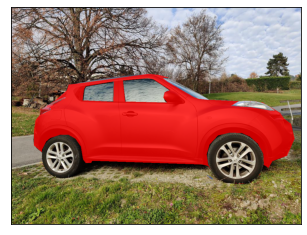

In [5]:
# посмотрим на маску кузова
idx = np.random.randint(0, len(img_list))

img_path = img_list[idx]
mask_path = mask_list[idx]

img = make_grid(read_image(str(img_path)))
# бывает, что у изображения 4 канала
if img.size()[0] == 4:
    img = img[:3, :, :]

mask = read_image(str(mask_path))

# 1 - это маска кузова авто
mask_body = mask == 1

drawn_masks = []
drawn_masks.append(draw_segmentation_masks(img, mask_body, alpha=0.8, colors="red"))

show(drawn_masks)

In [6]:
# make dataset
from torch.utils.data import Dataset, DataLoader

In [7]:
class CarBodyDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        img_paths = list(Path(img_dir).glob('*'))
        mask_paths = list(Path(mask_dir).glob('*'))
        assert len(img_paths) != 0, f'Картинки в {img_dir} отсутствуют'
        assert len(img_paths) == len(mask_paths), \
                f'Кол-во картинок и масок к ним не совпадает {(len(img_paths), len(mask_paths))}'
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.len_dataset = len(img_paths)
        
    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, idx):
        img = read_image(str(self.img_paths[idx]))
        # бывает, что у изображения 4 канала
        if img.size()[0] == 4:
            img = img[:3, :, :]

        
        mask = read_image(str(self.mask_paths[idx]))
        # 1 - это маска кузова авто
        mask_body = mask == 1
        sample = {'img': img, 'mask': mask_body}
        return sample
    

    


In [8]:
data = CarBodyDataset(IMAGES, MASKS)

In [9]:
data[0]

{'img': tensor([[[179, 184, 179,  ...,  96, 102, 110],
          [180, 184, 179,  ...,  87,  92,  91],
          [181, 185, 180,  ..., 124, 136, 126],
          ...,
          [155, 161, 169,  ..., 140, 147, 145],
          [157, 158, 157,  ..., 145, 149, 147],
          [160, 161, 153,  ..., 144, 145, 143]],
 
         [[117, 122, 118,  ...,  70,  74,  81],
          [118, 122, 118,  ...,  59,  64,  62],
          [119, 123, 119,  ...,  97, 107,  94],
          ...,
          [150, 156, 164,  ..., 136, 143, 141],
          [152, 153, 152,  ..., 141, 145, 143],
          [155, 156, 148,  ..., 140, 141, 139]],
 
         [[ 96, 101,  97,  ...,  55,  60,  67],
          [ 97, 101,  97,  ...,  45,  50,  48],
          [ 98, 102,  98,  ...,  80,  91,  79],
          ...,
          [144, 150, 158,  ..., 127, 134, 132],
          [146, 147, 146,  ..., 130, 134, 132],
          [149, 150, 142,  ..., 129, 130, 128]]], dtype=torch.uint8),
 'mask': tensor([[[False, False, False,  ..., False, Fal

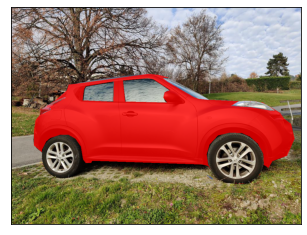

In [200]:
#idx = np.random.randint(0, len(data))
idx
sample = data[idx]
img = draw_segmentation_masks(sample['img'], sample['mask'], alpha=0.8, colors="red")
show(img)

In [14]:
class Scaler(object):
    """Отмасштабировать изображения сохранив пропорции.
    
    Пустые места будут заполнены отражениями.

    Аргументы:
        image: Изображение в HWC формате.
        size: Требуемый размер, пара W, H.
    """
    def __init__(self, size):
        self._size = size
        self._padding = 0
    
    def set_padding(self, padding):
        self._padding = padding
        
    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        grayscale = (len(image.shape) == 2)
        if grayscale:
            image = image[..., None]
        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2
        # Используем zeros на случай маленьких изображений.
        # TODO: фикс индексирования для маленьких изображений.
        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(image, (sw, sh),
                   interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
                   dst=result[offset_y:offset_y + sh, offset_x:offset_x + sw])

        # Отразить.
        result[offset_y:offset_y + sh, :offset_x] = result[offset_y:offset_y + sh, offset_x:2 * offset_x][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y:offset_y + sh, offset_x + sw:] = result[offset_y:offset_y + sh, sw + offset_x - offset_end:sw + offset_x][:, ::-1]
        
        result[:offset_y] = result[offset_y:2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh:] = result[sh + offset_y - offset_end:sh + offset_y][::-1]
        
        if grayscale:
            result = result[:, :, 0]
        return result

    
def remove_borders_inplace(mask):
    mask[mask == 255] = 0
    return mask

In [329]:
type(sample['img'])

torch.Tensor

In [356]:
class ToFloatTensor(object):
    def __call__(self, img):
        return img.type('torch.FloatTensor')

trf_img = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(0.7,0.7,0.7,0),
    #ToFloatTensor(),
    #transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

trf_mask = transforms.Compose([
    transforms.Resize(256),
])


torch.Size([3, 256, 341]) torch.Size([1, 256, 341])


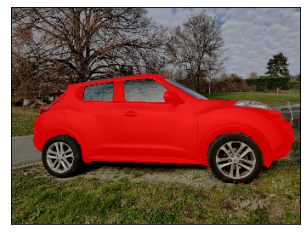

In [410]:
print(trf_img(sample['img']).size(), trf_mask(sample['mask']).size())
img = draw_segmentation_masks(trf_img(sample['img']), trf_mask(sample['mask']), alpha=0.8, colors="red")
show(img)

In [411]:
dataloader = DataLoader(data, batch_size=3, shuffle=True)

In [413]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/eugk/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [414]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1